=== epoch: 1 , iteration: 0 , train acc:0.295 , test acc:0.295 , train loss:1.596 ===
=== epoch: 2 , iteration: 250 , train acc:0.705 , test acc:0.7 , train loss:0.528 ===
=== epoch: 3 , iteration: 500 , train acc:0.717 , test acc:0.708 , train loss:0.712 ===
=== epoch: 4 , iteration: 750 , train acc:0.737 , test acc:0.722 , train loss:0.475 ===
=== epoch: 5 , iteration: 1000 , train acc:0.721 , test acc:0.707 , train loss:0.615 ===
=== epoch: 98 , iteration: 24250 , train acc:0.795 , test acc:0.762 , train loss:0.481 ===
=== epoch: 99 , iteration: 24500 , train acc:0.785 , test acc:0.758 , train loss:0.53 ===
=== epoch: 100 , iteration: 24750 , train acc:0.798 , test acc:0.761 , train loss:0.354 ===
=== epoch: 101 , iteration: 25000 , train acc:0.794 , test acc:0.768 , train loss:0.432 ===
=== epoch: 102 , iteration: 25250 , train acc:0.793 , test acc:0.765 , train loss:0.453 ===
=== epoch: 495 , iteration: 123500 , train acc:0.811 , test acc:0.768 , train loss:0.398 ===
=== epoch: 49

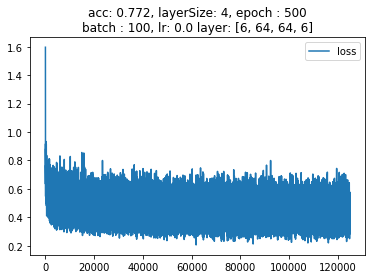

=== epoch: 1 , iteration: 0 , train acc:0.414 , test acc:0.414 , train loss:1.465 ===
=== epoch: 2 , iteration: 250 , train acc:0.701 , test acc:0.688 , train loss:0.626 ===
=== epoch: 3 , iteration: 500 , train acc:0.726 , test acc:0.715 , train loss:0.564 ===
=== epoch: 4 , iteration: 750 , train acc:0.74 , test acc:0.73 , train loss:0.551 ===
=== epoch: 5 , iteration: 1000 , train acc:0.748 , test acc:0.726 , train loss:0.423 ===
=== epoch: 98 , iteration: 24250 , train acc:0.802 , test acc:0.769 , train loss:0.381 ===
=== epoch: 99 , iteration: 24500 , train acc:0.805 , test acc:0.767 , train loss:0.503 ===
=== epoch: 100 , iteration: 24750 , train acc:0.791 , test acc:0.754 , train loss:0.393 ===
=== epoch: 101 , iteration: 25000 , train acc:0.803 , test acc:0.77 , train loss:0.512 ===
=== epoch: 102 , iteration: 25250 , train acc:0.804 , test acc:0.767 , train loss:0.515 ===
=== epoch: 495 , iteration: 123500 , train acc:0.816 , test acc:0.768 , train loss:0.466 ===
=== epoch: 49

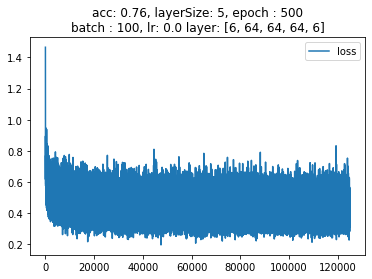

=== epoch: 1 , iteration: 0 , train acc:0.448 , test acc:0.453 , train loss:1.309 ===
=== epoch: 2 , iteration: 250 , train acc:0.705 , test acc:0.7 , train loss:0.699 ===
=== epoch: 3 , iteration: 500 , train acc:0.719 , test acc:0.711 , train loss:0.818 ===
=== epoch: 4 , iteration: 750 , train acc:0.737 , test acc:0.72 , train loss:0.61 ===
=== epoch: 5 , iteration: 1000 , train acc:0.742 , test acc:0.729 , train loss:0.536 ===
=== epoch: 98 , iteration: 24250 , train acc:0.789 , test acc:0.756 , train loss:0.553 ===
=== epoch: 99 , iteration: 24500 , train acc:0.795 , test acc:0.767 , train loss:0.55 ===
=== epoch: 100 , iteration: 24750 , train acc:0.8 , test acc:0.766 , train loss:0.399 ===
=== epoch: 101 , iteration: 25000 , train acc:0.791 , test acc:0.766 , train loss:0.488 ===
=== epoch: 102 , iteration: 25250 , train acc:0.79 , test acc:0.769 , train loss:0.417 ===
=== epoch: 495 , iteration: 123500 , train acc:0.793 , test acc:0.755 , train loss:0.361 ===
=== epoch: 496 , i

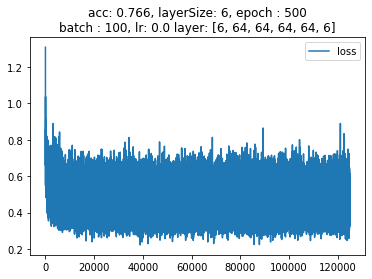

=== epoch: 1 , iteration: 0 , train acc:0.491 , test acc:0.484 , train loss:1.202 ===
=== epoch: 2 , iteration: 250 , train acc:0.715 , test acc:0.706 , train loss:0.606 ===
=== epoch: 3 , iteration: 500 , train acc:0.725 , test acc:0.715 , train loss:0.576 ===
=== epoch: 4 , iteration: 750 , train acc:0.754 , test acc:0.74 , train loss:0.604 ===
=== epoch: 5 , iteration: 1000 , train acc:0.748 , test acc:0.735 , train loss:0.542 ===
=== epoch: 98 , iteration: 24250 , train acc:0.811 , test acc:0.766 , train loss:0.37 ===
=== epoch: 99 , iteration: 24500 , train acc:0.809 , test acc:0.768 , train loss:0.416 ===
=== epoch: 100 , iteration: 24750 , train acc:0.814 , test acc:0.766 , train loss:0.355 ===
=== epoch: 101 , iteration: 25000 , train acc:0.806 , test acc:0.766 , train loss:0.42 ===
=== epoch: 102 , iteration: 25250 , train acc:0.805 , test acc:0.771 , train loss:0.486 ===
=== epoch: 495 , iteration: 123500 , train acc:0.841 , test acc:0.778 , train loss:0.351 ===
=== epoch: 49

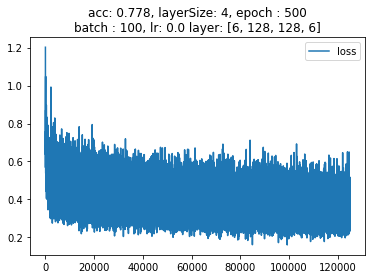

=== epoch: 1 , iteration: 0 , train acc:0.519 , test acc:0.527 , train loss:1.135 ===
=== epoch: 2 , iteration: 250 , train acc:0.722 , test acc:0.709 , train loss:0.729 ===
=== epoch: 3 , iteration: 500 , train acc:0.735 , test acc:0.724 , train loss:0.586 ===
=== epoch: 4 , iteration: 750 , train acc:0.752 , test acc:0.734 , train loss:0.613 ===
=== epoch: 5 , iteration: 1000 , train acc:0.759 , test acc:0.746 , train loss:0.561 ===
=== epoch: 98 , iteration: 24250 , train acc:0.813 , test acc:0.767 , train loss:0.337 ===
=== epoch: 99 , iteration: 24500 , train acc:0.816 , test acc:0.779 , train loss:0.488 ===
=== epoch: 100 , iteration: 24750 , train acc:0.814 , test acc:0.769 , train loss:0.345 ===
=== epoch: 101 , iteration: 25000 , train acc:0.806 , test acc:0.771 , train loss:0.507 ===
=== epoch: 102 , iteration: 25250 , train acc:0.807 , test acc:0.766 , train loss:0.436 ===
=== epoch: 495 , iteration: 123500 , train acc:0.821 , test acc:0.771 , train loss:0.432 ===
=== epoch:

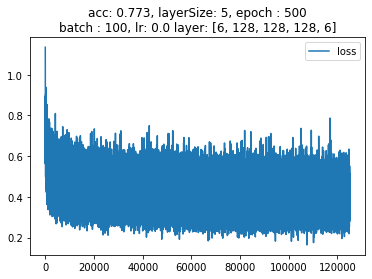

=== epoch: 1 , iteration: 0 , train acc:0.479 , test acc:0.48 , train loss:1.146 ===
=== epoch: 2 , iteration: 250 , train acc:0.718 , test acc:0.71 , train loss:0.683 ===
=== epoch: 3 , iteration: 500 , train acc:0.728 , test acc:0.711 , train loss:0.691 ===
=== epoch: 4 , iteration: 750 , train acc:0.731 , test acc:0.722 , train loss:0.568 ===
=== epoch: 5 , iteration: 1000 , train acc:0.745 , test acc:0.735 , train loss:0.499 ===
=== epoch: 98 , iteration: 24250 , train acc:0.791 , test acc:0.763 , train loss:0.337 ===
=== epoch: 99 , iteration: 24500 , train acc:0.797 , test acc:0.766 , train loss:0.523 ===
=== epoch: 100 , iteration: 24750 , train acc:0.79 , test acc:0.758 , train loss:0.462 ===
=== epoch: 101 , iteration: 25000 , train acc:0.792 , test acc:0.765 , train loss:0.499 ===
=== epoch: 102 , iteration: 25250 , train acc:0.792 , test acc:0.76 , train loss:0.489 ===
=== epoch: 495 , iteration: 123500 , train acc:0.792 , test acc:0.761 , train loss:0.469 ===
=== epoch: 496

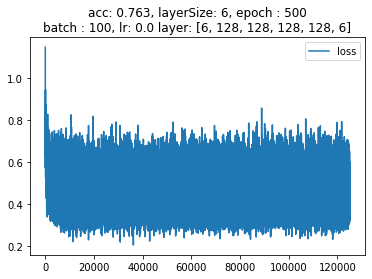

=== epoch: 1 , iteration: 0 , train acc:0.396 , test acc:0.399 , train loss:1.543 ===
=== epoch: 2 , iteration: 250 , train acc:0.711 , test acc:0.701 , train loss:0.554 ===
=== epoch: 3 , iteration: 500 , train acc:0.723 , test acc:0.718 , train loss:0.649 ===
=== epoch: 4 , iteration: 750 , train acc:0.727 , test acc:0.715 , train loss:0.606 ===
=== epoch: 5 , iteration: 1000 , train acc:0.731 , test acc:0.716 , train loss:0.462 ===
=== epoch: 98 , iteration: 24250 , train acc:0.797 , test acc:0.766 , train loss:0.472 ===
=== epoch: 99 , iteration: 24500 , train acc:0.799 , test acc:0.769 , train loss:0.432 ===
=== epoch: 100 , iteration: 24750 , train acc:0.8 , test acc:0.768 , train loss:0.361 ===
=== epoch: 101 , iteration: 25000 , train acc:0.797 , test acc:0.772 , train loss:0.452 ===
=== epoch: 102 , iteration: 25250 , train acc:0.799 , test acc:0.778 , train loss:0.522 ===
=== epoch: 495 , iteration: 123500 , train acc:0.812 , test acc:0.771 , train loss:0.375 ===
=== epoch: 4

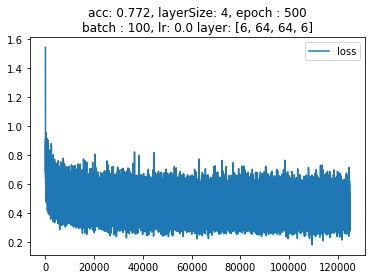

=== epoch: 1 , iteration: 0 , train acc:0.51 , test acc:0.51 , train loss:1.417 ===
=== epoch: 2 , iteration: 250 , train acc:0.694 , test acc:0.692 , train loss:0.692 ===
=== epoch: 3 , iteration: 500 , train acc:0.731 , test acc:0.719 , train loss:0.56 ===
=== epoch: 4 , iteration: 750 , train acc:0.736 , test acc:0.732 , train loss:0.588 ===
=== epoch: 5 , iteration: 1000 , train acc:0.745 , test acc:0.73 , train loss:0.689 ===
=== epoch: 98 , iteration: 24250 , train acc:0.796 , test acc:0.771 , train loss:0.408 ===
=== epoch: 99 , iteration: 24500 , train acc:0.798 , test acc:0.768 , train loss:0.401 ===
=== epoch: 100 , iteration: 24750 , train acc:0.804 , test acc:0.767 , train loss:0.444 ===
=== epoch: 101 , iteration: 25000 , train acc:0.806 , test acc:0.77 , train loss:0.357 ===
=== epoch: 102 , iteration: 25250 , train acc:0.807 , test acc:0.769 , train loss:0.52 ===
=== epoch: 495 , iteration: 123500 , train acc:0.81 , test acc:0.766 , train loss:0.359 ===
=== epoch: 496 , 

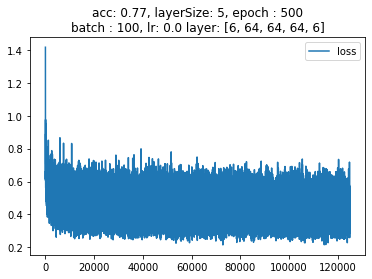

=== epoch: 1 , iteration: 0 , train acc:0.482 , test acc:0.489 , train loss:1.489 ===
=== epoch: 2 , iteration: 250 , train acc:0.689 , test acc:0.681 , train loss:0.642 ===
=== epoch: 3 , iteration: 500 , train acc:0.727 , test acc:0.712 , train loss:0.627 ===
=== epoch: 4 , iteration: 750 , train acc:0.737 , test acc:0.72 , train loss:0.567 ===
=== epoch: 5 , iteration: 1000 , train acc:0.739 , test acc:0.721 , train loss:0.681 ===
=== epoch: 98 , iteration: 24250 , train acc:0.79 , test acc:0.772 , train loss:0.408 ===
=== epoch: 99 , iteration: 24500 , train acc:0.795 , test acc:0.766 , train loss:0.365 ===
=== epoch: 100 , iteration: 24750 , train acc:0.794 , test acc:0.769 , train loss:0.492 ===
=== epoch: 101 , iteration: 25000 , train acc:0.797 , test acc:0.766 , train loss:0.473 ===
=== epoch: 102 , iteration: 25250 , train acc:0.791 , test acc:0.757 , train loss:0.555 ===
=== epoch: 495 , iteration: 123500 , train acc:0.794 , test acc:0.764 , train loss:0.525 ===
=== epoch: 4

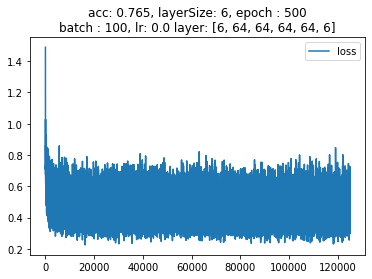

=== epoch: 1 , iteration: 0 , train acc:0.481 , test acc:0.483 , train loss:1.281 ===
=== epoch: 2 , iteration: 250 , train acc:0.703 , test acc:0.701 , train loss:0.749 ===
=== epoch: 3 , iteration: 500 , train acc:0.729 , test acc:0.723 , train loss:0.709 ===
=== epoch: 4 , iteration: 750 , train acc:0.743 , test acc:0.731 , train loss:0.544 ===
=== epoch: 5 , iteration: 1000 , train acc:0.741 , test acc:0.724 , train loss:0.632 ===
=== epoch: 98 , iteration: 24250 , train acc:0.813 , test acc:0.77 , train loss:0.425 ===
=== epoch: 99 , iteration: 24500 , train acc:0.82 , test acc:0.773 , train loss:0.496 ===
=== epoch: 100 , iteration: 24750 , train acc:0.814 , test acc:0.772 , train loss:0.383 ===
=== epoch: 101 , iteration: 25000 , train acc:0.81 , test acc:0.772 , train loss:0.569 ===
=== epoch: 102 , iteration: 25250 , train acc:0.813 , test acc:0.768 , train loss:0.473 ===
=== epoch: 495 , iteration: 123500 , train acc:0.836 , test acc:0.766 , train loss:0.376 ===
=== epoch: 49

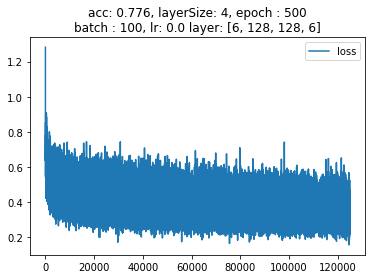

=== epoch: 1 , iteration: 0 , train acc:0.556 , test acc:0.558 , train loss:1.121 ===
=== epoch: 2 , iteration: 250 , train acc:0.707 , test acc:0.696 , train loss:0.537 ===
=== epoch: 3 , iteration: 500 , train acc:0.741 , test acc:0.724 , train loss:0.601 ===
=== epoch: 4 , iteration: 750 , train acc:0.751 , test acc:0.737 , train loss:0.545 ===
=== epoch: 5 , iteration: 1000 , train acc:0.754 , test acc:0.731 , train loss:0.465 ===
=== epoch: 98 , iteration: 24250 , train acc:0.804 , test acc:0.76 , train loss:0.367 ===
=== epoch: 99 , iteration: 24500 , train acc:0.807 , test acc:0.773 , train loss:0.467 ===
=== epoch: 100 , iteration: 24750 , train acc:0.815 , test acc:0.774 , train loss:0.319 ===
=== epoch: 101 , iteration: 25000 , train acc:0.807 , test acc:0.773 , train loss:0.434 ===
=== epoch: 102 , iteration: 25250 , train acc:0.813 , test acc:0.769 , train loss:0.475 ===
=== epoch: 495 , iteration: 123500 , train acc:0.821 , test acc:0.772 , train loss:0.311 ===
=== epoch: 

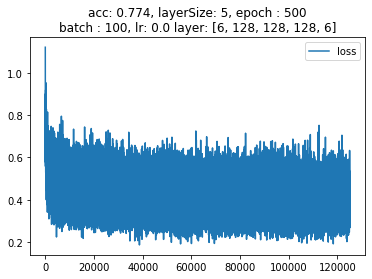

=== epoch: 1 , iteration: 0 , train acc:0.512 , test acc:0.503 , train loss:1.21 ===
=== epoch: 2 , iteration: 250 , train acc:0.718 , test acc:0.712 , train loss:0.561 ===
=== epoch: 3 , iteration: 500 , train acc:0.741 , test acc:0.728 , train loss:0.63 ===
=== epoch: 4 , iteration: 750 , train acc:0.75 , test acc:0.736 , train loss:0.444 ===


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [185]:
# coding: utf-8
# 2020/인공지능/final/B511074/박준형
import sys, os
import argparse
import time
sys.path.append(os.pardir)
from collections import OrderedDict
import matplotlib.pyplot as plt
import pickle
import numpy as np
import math
from AReM import *


def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)

        return y.T

    x = x - np.max(x)  # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))


def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)

    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x<=0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        
        return dout


class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
#         eMIN = -np.log(np.finfo(type(0.1)).max)
#         x = np.array(np.maximum(x, eMIN))
        self.out = 1.0 / (1 + np.exp(-x))
        
        return self.out

    def backward(self, dout):
        dx = dout * self.out * (1 - self.out)
        
        return dx

class tanh:
    def __init__(self):
        self.out = None
    
    def forward(self, x):
        self.out = np.tanh(x)
        
        return self.out
    
    def backward(self, dout):
        dx = dout * (1 - self.out**2)
        
        return dx

class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x, self.dw, self.db = None, None, None

    def forward(self, x):
        self.x = x

        out = np.dot(x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dw = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)

        return dx

class SoftmaxWithLoss:
    def __init__(self):
        self.t = None
        self.y = None

    def forward(self, x, t):
        if t.ndim == 1: #one hot 안되어 있는 경우
            t = np.eye(6)[t]
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)

        return self.loss

    def backward(self, dout=1):
        
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size

        return dx

class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr

    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

class Momentum:
    def __init__(self, lr = 0.01, momentum = 0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
                
            for key in params.keys():
                self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
                params[key] += self.v[key]
                
class Adagrad:
    def __init__(self, lr = 0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
                
            for key in params.keys():
                self.h[key] = grads[key] * grads[key]
                params[key] -= self.lr * grads[key] / np.sqrt(self.h[key] + 1e-7)
class RMSprop:
    def __init__(self, lr=0.01, decay_rate = 0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] *= self.decay_rate
            self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)
            
class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                if key is 'mean' or key is 'std':
                    continue
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            if key is 'mean' or key is 'std':
                continue
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
class CustomOptimizer:
    pass

class Dropout:
    def __init__(self, dropout_ratio = 0.1):
        self.dropout_ratio = dropout_ratio
        self.mask = None
    
    def forward(self, x, train_flg = False):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            
            return x * self.mask
        
        else:
            return x * (1.0 - self.dropout_ratio)
        
    def backward(self, dout):
        return dout * self.mask
    
def weight_init_std(input, type = 'Relu'):
    """ 가중치 초깃값 """

    # he 초깃값 -> Relu
    if type is 'Relu':
        return np.sqrt(2.0 / input)
      
    # Xavier 초깃값 -> sigmoid, tanh
    elif type is 'Sigmoid' or type is 'tanh':
        return 1.0 / np.sqrt(input)
    
class Model:
    """
    네트워크 모델 입니다.

    """
    """제출 전 수정"""
    def __init__(self, mean = None, std = None, dropFlag = False, layer_unit = [6, 32, 32, 6], lr=0.005):
        """
        클래스 초기화
        """
        
        self.dropFlag = dropFlag #
        self.params = {}
        self.params['mean'] = mean
        self.params['std'] = std
        """제출 전 수정"""
        self.W = {} #
        self.layer_unit = layer_unit
        self.layer_size = len(layer_unit) # 레이어 수
        self.__init_weight()
        self.layers = OrderedDict()
        self.last_layer = None
        self.__init_layer()
        self.optimizer = Adam(lr)
        
    def __init_layer(self):
        """
        레이어를 생성하시면 됩니다.
        """
        # Input layer -> hidden layer -> hidden...
        for i in range(1, self.layer_size - 1):
            self.layers['Affine{}'.format(i)] = \
                Affine(self.params['W{}'.format(i)], self.params['b{}'.format(i)])
            
            self.layers['tanh{}'.format(i)] = tanh() #Activation Function
            
            # dropOut
            if self.dropFlag:
                self.layers['Dropout{}'.format(i)] = Dropout()
        
        # hidden layer -> output
        i = self.layer_size - 1
        self.layers['Affine{}'.format(i)] = \
            Affine(self.params['W{}'.format(i)], self.params['b{}'.format(i)])
        
        self.last_layer = SoftmaxWithLoss()
        
    def __init_weight(self):
        """
        레이어에 탑재 될 파라미터들을 초기화 하시면 됩니다.
        """
    
        for i in range(1, self.layer_size):
            self.params['W{}'.format(i)] = weight_init_std(self.layer_unit[i - 1], 'tanh') \
                        * np.random.randn(self.layer_unit[i - 1], self.layer_unit[i]) 
            self.params['b{}'.format(i)] = np.zeros(self.layer_unit[i])
            
            # 초기 Weight값 확인
            self.W['W{}'.format(i)] = self.params['W{}'.format(i)].copy()
            self.W['b{}'.format(i)] = self.params['b{}'.format(i)].copy()
        
    def update(self, x, t, dropFlag = False):
        """
        train 데이터와 레이블을 사용해서 그라디언트를 구한 뒤
         옵티마이저 클래스를 사용해서 네트워크 파라미터를 업데이트 해주는 함수입니다.

        :param x: train_data
        :param t: test_data
        """
        
        self.dropFlag = dropFlag
        grads = self.gradient(x, t)
        self.optimizer.update(self.params, grads)

    def predict(self, x):
        """
        데이터를 입력받아 정답을 예측하는 함수입니다.

        :param x: data
        :return: predicted answer
        """
        x2 = x.copy()
        x2 -= self.params['mean']
        x2 /= self.params['std']
        for key, layer in self.layers.items():
            if "Dropout" in key:
                
                x2 = layer.forward(x2, self.dropFlag)
                
            else:
                x2 = layer.forward(x2)
        self.dropFlag=False
        return x2

    def loss(self, x, t):
        """
        데이터와 레이블을 입력받아 로스를 구하는 함수입니다.
        :param x: data
        :param t: data_label
        :return: loss
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def gradient(self, x, t):
        """
        train 데이터와 레이블을 사용해서 그라디언트를 구하는 함수입니다.
        첫번째로 받은데이터를 forward propagation 시키고,
        두번째로 back propagation 시켜 grads에 미분값을 리턴합니다.
        :param x: data
        :param t: data_label
        :return: grads
        """
        # forward
        self.loss(x, t)
        
        # backward
        dout = self.last_layer.backward(1)
        
        la = list(self.layers.values())
        la.reverse()
        
        for layer in la:
            dout = layer.backward(dout)
        
        # 결과 저장
        grads = {}
        
        for i in range(1, self.layer_size):
            grads['W{}'.format(i)] = self.layers['Affine{}'.format(i)].dw
            grads['b{}'.format(i)] = self.layers['Affine{}'.format(i)].db
                
        return grads

    def save_params(self, file_name="params.pkl"):
        """
        네트워크 파라미터를 피클 파일로 저장하는 함수입니다.

        :param file_name: 파라미터를 저장할 파일 이름입니다. 기본값은 "params.pkl" 입니다.
        """
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        """
        저장된 파라미터를 읽어와 네트워크에 탑재하는 함수입니다.

        :param file_name: 파라미터를 로드할 파일 이름입니다. 기본값은 "params.pkl" 입니다.
        """
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val
        self.__init_layer()

class Trainer:
    """
    ex) 200개의 훈련데이터셋, 배치사이즈=5, 에폭=1000 일 경우 :
    40개의 배치(배치당 5개 데이터)를 에폭 갯수 만큼 업데이트 하는것.=
    (200 / 5) * 1000 = 40,000번 업데이트.

    ----------
    network : 네트워크
    x_train : 트레인 데이터
    t_train : 트레인 데이터에 대한 라벨
    x_test : 발리데이션 데이터
    t_test : 발리데이션 데이터에 대한 라벨
    epochs : 에폭 수
    mini_batch_size : 미니배치 사이즈
    learning_rate : 학습률
    verbose : 출력여부

    ----------
    """
    def __init__(self, network, x_train, t_train, x_test, t_test,
                 epochs=20, mini_batch_size=100,
                 learning_rate=0.01, verbose=True, layers = []):
        self.network = network
        self.x_train = x_train
        self.t_train = t_train
        self.x_test = x_test
        self.t_test = t_test
        self.epochs = int(epochs)
        self.batch_size = int(mini_batch_size)
        self.lr = learning_rate
        self.verbose = verbose
        self.train_size = x_train.shape[0]
        self.iter_per_epoch = int(max(self.train_size / self.batch_size, 1))
        self.max_iter = int(self.epochs * self.iter_per_epoch)
        self.current_iter = 0
        self.current_epoch = 0

        self.train_loss_list = []
        self.train_acc_list = []
        self.test_acc_list = []

        """제출 전 수정"""
        self.layers = layers # List : ex) [6, 32, 32, 6]
        self.layer_size = len(layers)
        self.test_acc = None
        
    def train_step(self):
        # 렌덤 트레인 배치 생성
        batch_mask = np.random.choice(self.train_size, self.batch_size)
        x_batch = self.x_train[batch_mask]
        t_batch = self.t_train[batch_mask]

        # 네트워크 업데이트
        self.network.update(x_batch, t_batch, True)
        loss = self.network.loss(x_batch, t_batch)
        self.train_loss_list.append(loss)

        if self.current_iter % self.iter_per_epoch == 0:
            self.current_epoch += 1
            
            train_acc, _ = self.accuracy(self.x_train, self.t_train)
            test_acc, _ = self.accuracy(self.x_test, self.t_test)
            self.train_acc_list.append(train_acc)
            self.test_acc_list.append(test_acc)
            if self.verbose is False and ((self.current_epoch <= 5) or (self.current_epoch>=98 and\
                                          self.current_epoch<=102) or\
                                          ((self.current_epoch) >= (self.epochs - 5))): 
                print("=== epoch:", str(round(self.current_epoch, 3)), ", iteration:", str(round(self.current_iter, 3)),
                ", train acc:" + str(round(train_acc, 3)), ", test acc:" + str(round(test_acc, 3)), ", train loss:" + str(round(loss, 3)) + " ===")
        self.current_iter += 1

    def train(self):
        for i in range(self.max_iter):
            self.train_step()
        self.test_acc, inference_time = self.accuracy(self.x_test, self.t_test)
        if self.verbose:
            """제출 전 수정"""
            file = open('./Result/SGD/[si_{}]_[ep_{}]_[ba_{}]_[lr_{}]_[la_{}].txt'\
                        .format(self.layer_size, self.epochs, self.batch_size, self.lr, self.layers), 'w')
            file.write("=============== Final Test Accuracy ===============\n")
            file.write("test acc: %f,  " % self.test_acc)
            file.write("inference_time: %f\n" % inference_time)
            file.close()
        else:
            print("=============== Final Test Accuracy ===============")
            print("test acc:" + str(self.test_acc) + ", inference_time:" + str(inference_time))
            print('[size = {}][epoch = {}][batch = {}][lr = {}][layer = {}]'\
                        .format(self.layer_size, self.epochs, self.batch_size, self.lr, self.layers))
            print("")

    def accuracy(self, x, t):
        if t.ndim != 1: t = np.argmax(t, axis=1)

        acc = 0.0
        start_time = time.time()

        for i in range(int(x.shape[0] / self.batch_size)):
            
            tx = x[i * self.batch_size:(i + 1) * self.batch_size]
            tt = t[i * self.batch_size:(i + 1) * self.batch_size]
            y = self.network.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt)

        inference_time = (time.time() - start_time) / x.shape[0]

        return acc / x.shape[0], inference_time

class Tester:
    """
    test 해주는 클래스. 수정불가
    ----------
    network : 네트워크
    x_test : 발리데이션 데이터
    t_test : 발리데이션 데이터에 대한 라벨
    mini_batch_size : 미니배치 사이즈
    verbose : 출력여부

    ----------
    """
    def __init__(self, network, x_test, t_test, mini_batch_size=100, verbose=True):
        self.network = network
        self.x_test = x_test
        self.t_test = t_test
        self.batch_size = int(mini_batch_size)
        self.verbose = verbose
        self.train_size = x_test.shape[0]

    def accuracy(self, x, t):
        """
        수정불가
        """
        if t.ndim != 1: t = np.argmax(t, axis=1)

        acc = 0.0
        start_time = time.time()

        for i in range(int(x.shape[0] / self.batch_size)):
            tx = x[i * self.batch_size:(i + 1) * self.batch_size]
            tt = t[i * self.batch_size:(i + 1) * self.batch_size]
            
            y = self.network.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt)

        inference_time = (time.time()-start_time)/x.shape[0]

        return acc / x.shape[0], inference_time

class arg:
    def __init__(self, epochs, mini_batch_size, learning_rate, sf):
        self.sf = sf
        self.epochs =  epochs
        self.mini_batch_size = mini_batch_size
        self.learning_rate = learning_rate
        
if __name__ == '__main__':
#     parser = argparse.ArgumentParser(description="train.py --help 로 설명을 보시면 됩니다."
#                                                  "사용예)python train.py --sf=myparam --epochs=10")
#     parser.add_argument("--sf", required=False, default="params.pkl", help="save_file_name")
#     parser.add_argument("--epochs", required=False, default=20, help="epochs : default=20")
#     parser.add_argument("--mini_batch_size", required=False, default=100, help="mini_batch_size : default=100")
#     parser.add_argument("--learning_rate", required=False, default=0.01, help="learning_rate : default=0.01")
#     args = parser.parse_args()

    # 데이터셋 탑재
    (x_train, t_train), (x_test, t_test) = load_AReM(standardze = False, one_hot_label=False)
    
    mean = np.mean(x_train, axis = 0)
    std = np.std(x_train, axis=0)
    
    """제출전 수정"""
    # hyperparameter
    train_acc = []
    test_acc = []
    epochs = [500]
    batchs = [100]
    learningRate = []
    for i in range(10):
        learningRate.append(10 ** np.random.uniform (-6, -2))
    layer_unit_list = [[6, 64, 64, 6], [6, 64, 64, 64, 6], [6, 64, 64, 64, 64, 6], 
                       [6, 128, 128, 6], [6, 128, 128, 128, 6], [6, 128, 128, 128, 128, 6]]
    for epoch in epochs:
        for batch in batchs:
            for lr in learningRate:
                for layer_unit in layer_unit_list:
                    sf = './Params/Adam/params[si={}][ep={}][ba={}][lr={}][la={}].pkl'\
                        .format(len(layer_unit), epoch, batch, lr, layer_unit)
                    args = arg(epoch, batch, lr, sf)

                    # 모델 초기화
                    network = Model(mean, std, True, layer_unit)

                    # 트레이너 초기화
                    trainer = Trainer(network, x_train, t_train, x_test, t_test,
                                      epochs=args.epochs, mini_batch_size=args.mini_batch_size,
                                      learning_rate=args.learning_rate, verbose=False, 
                                      layers = layer_unit)

                    # 트레이너를 사용해 모델 학습
                    trainer.train()
                    # 파라미터 보관
                    network.save_params(args.sf) 
                    
                    # loss와 training accuracy를 Plot
                    x = np.arange(len(trainer.train_loss_list))
                    plt.plot(x, trainer.train_loss_list)
                    plt.legend(["loss"]) # 각주
                    plt.title('acc: {}, layerSize: {}, epoch : {}\nbatch : {}, lr: {} layer: {}'\
                              .format(round(trainer.test_acc, 3), len(layer_unit), epoch, batch, \
                                      round(lr, 3), layer_unit))
                    plt.savefig('./Result/Adam/tanh/{}[si_{}]_[ep_{}]_[ba_{}]_[lr_{}]_[la_{}].png'\
                                .format(round(trainer.test_acc, 3), len(layer_unit), epoch, batch,\
                                        round(lr, 3), layer_unit), dpi=100)
                    plt.show()
                    plt.clf()

=== epoch: 1 , iteration: 0 , train acc:0.23 , test acc:0.235 , train loss:1.854 ===
=== epoch: 2 , iteration: 250 , train acc:0.713 , test acc:0.708 , train loss:0.644 ===
=== epoch: 3 , iteration: 500 , train acc:0.721 , test acc:0.71 , train loss:0.592 ===
=== epoch: 4 , iteration: 750 , train acc:0.727 , test acc:0.721 , train loss:0.558 ===
=== epoch: 5 , iteration: 1000 , train acc:0.733 , test acc:0.721 , train loss:0.653 ===
=== epoch: 98 , iteration: 24250 , train acc:0.799 , test acc:0.764 , train loss:0.509 ===
=== epoch: 99 , iteration: 24500 , train acc:0.802 , test acc:0.77 , train loss:0.46 ===
=== epoch: 100 , iteration: 24750 , train acc:0.802 , test acc:0.771 , train loss:0.529 ===
=== epoch: 101 , iteration: 25000 , train acc:0.797 , test acc:0.761 , train loss:0.409 ===
=== epoch: 102 , iteration: 25250 , train acc:0.801 , test acc:0.775 , train loss:0.41 ===
=== epoch: 495 , iteration: 123500 , train acc:0.816 , test acc:0.773 , train loss:0.393 ===
=== epoch: 496 

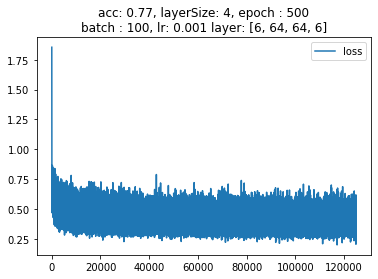

<Figure size 432x288 with 0 Axes>

In [1]:
#1111
# coding: utf-8
# 2020/인공지능/final/B511074/박준형
import sys, os
import argparse
import time
sys.path.append(os.pardir)
from collections import OrderedDict
import matplotlib.pyplot as plt
import pickle
import numpy as np
import math
from AReM import *


def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)

        return y.T

    x = x - np.max(x)  # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))


def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)

    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x<=0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        
        return dout


class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
#         eMIN = -np.log(np.finfo(type(0.1)).max)
#         x = np.array(np.maximum(x, eMIN))
        self.out = 1.0 / (1 + np.exp(-x))
        
        return self.out

    def backward(self, dout):
        dx = dout * self.out * (1 - self.out)
        
        return dx

class tanh:
    def __init__(self):
        self.out = None
    
    def forward(self, x):
        self.out = np.tanh(x)
        
        return self.out
    
    def backward(self, dout):
        dx = dout * (1 - self.out**2)
        
        return dx

class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x, self.dw, self.db = None, None, None

    def forward(self, x):
        self.x = x

        out = np.dot(x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dw = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)

        return dx

class SoftmaxWithLoss:
    def __init__(self):
        self.t = None
        self.y = None

    def forward(self, x, t):
        if t.ndim == 1: #one hot 안되어 있는 경우
            t = np.eye(6)[t]
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)

        return self.loss

    def backward(self, dout=1):
        
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size

        return dx

class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr

    def update(self, params, grads):
        for key in params.keys():
            if key is 'mean' or key is 'std':
                    continue
            params[key] -= self.lr * grads[key]

class Momentum:
    def __init__(self, lr = 0.01, momentum = 0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                if key is 'mean' or key is 'std':
                    continue
                self.v[key] = np.zeros_like(val)
                
            for key in params.keys():
                if key is 'mean' or key is 'std':
                    continue
                self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
                params[key] += self.v[key]
                
class Adagrad:
    def __init__(self, lr = 0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                if key is 'mean' or key is 'std':
                    continue
                self.h[key] = np.zeros_like(val)
                
            for key in params.keys():
                if key is 'mean' or key is 'std':
                    continue
                self.h[key] = grads[key] * grads[key]
                params[key] -= self.lr * grads[key] / np.sqrt(self.h[key] + 1e-7)
            
class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                if key is 'mean' or key is 'std':
                    continue
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            if key is 'mean' or key is 'std':
                continue
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
class CustomOptimizer:
    pass

class Dropout:
    def __init__(self, dropout_ratio = 0.1):
        self.dropout_ratio = dropout_ratio
        self.mask = None
    
    def forward(self, x, train_flg = False):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            
            return x * self.mask
        
        else:
            return x * (1.0 - self.dropout_ratio)
        
    def backward(self, dout):
        return dout * self.mask
    
def weight_init_std(input, type = 'Relu'):
    """ 가중치 초깃값 """

    # he 초깃값 -> Relu
    if type is 'Relu':
        return np.sqrt(2.0 / input)
      
    # Xavier 초깃값 -> sigmoid, tanh
    elif type is 'Sigmoid' or type is 'tanh':
        return 1.0 / np.sqrt(input)
    
class Model:
    """
    네트워크 모델 입니다.

    """
    """제출 전 수정"""
    def __init__(self, mean = None, std = None, dropFlag = False, layer_unit = [6, 32, 32, 6], lr=0.005):
        """
        클래스 초기화
        """
        
        self.dropFlag = dropFlag #
        self.params = {}
        self.params['mean'] = mean
        self.params['std'] = std
        """제출 전 수정"""
        self.W = {} #
        self.layer_unit = layer_unit
        self.layer_size = len(layer_unit) # 레이어 수
        self.__init_weight()
        self.layers = OrderedDict()
        self.last_layer = None
        self.__init_layer()
        self.optimizer = Adam(lr)
        
    def __init_layer(self):
        """
        레이어를 생성하시면 됩니다.
        """
        # Input layer -> hidden layer -> hidden...
        for i in range(1, self.layer_size - 1):
            self.layers['Affine{}'.format(i)] = \
                Affine(self.params['W{}'.format(i)], self.params['b{}'.format(i)])
            
            self.layers['Relu{}'.format(i)] = Relu() #Activation Function
            
            # dropOut
            if self.dropFlag:
                self.layers['Dropout{}'.format(i)] = Dropout()
        
        # hidden layer -> output
        i = self.layer_size - 1
        self.layers['Affine{}'.format(i)] = \
            Affine(self.params['W{}'.format(i)], self.params['b{}'.format(i)])
        
        self.last_layer = SoftmaxWithLoss()
        
    def __init_weight(self):
        """
        레이어에 탑재 될 파라미터들을 초기화 하시면 됩니다.
        """
    
        for i in range(1, self.layer_size):
            self.params['W{}'.format(i)] = weight_init_std(self.layer_unit[i - 1], 'Relu') \
                        * np.random.randn(self.layer_unit[i - 1], self.layer_unit[i]) 
            self.params['b{}'.format(i)] = np.zeros(self.layer_unit[i])
            
            # 초기 Weight값 확인
            self.W['W{}'.format(i)] = self.params['W{}'.format(i)].copy()
            self.W['b{}'.format(i)] = self.params['b{}'.format(i)].copy()
        
    def update(self, x, t, dropFlag = False):
        """
        train 데이터와 레이블을 사용해서 그라디언트를 구한 뒤
         옵티마이저 클래스를 사용해서 네트워크 파라미터를 업데이트 해주는 함수입니다.

        :param x: train_data
        :param t: test_data
        """
        
        self.dropFlag = dropFlag
        grads = self.gradient(x, t)
        self.optimizer.update(self.params, grads)

    def predict(self, x):
        """
        데이터를 입력받아 정답을 예측하는 함수입니다.

        :param x: data
        :return: predicted answer
        """
        x2 = x.copy()
        x2 -= self.params['mean']
        x2 /= self.params['std']
        for key, layer in self.layers.items():
            if "Dropout" in key:
                
                x2 = layer.forward(x2, self.dropFlag)
                
            else:
                x2 = layer.forward(x2)
        self.dropFlag=False
        return x2

    def loss(self, x, t):
        """
        데이터와 레이블을 입력받아 로스를 구하는 함수입니다.
        :param x: data
        :param t: data_label
        :return: loss
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def gradient(self, x, t):
        """
        train 데이터와 레이블을 사용해서 그라디언트를 구하는 함수입니다.
        첫번째로 받은데이터를 forward propagation 시키고,
        두번째로 back propagation 시켜 grads에 미분값을 리턴합니다.
        :param x: data
        :param t: data_label
        :return: grads
        """
        # forward
        self.loss(x, t)
        
        # backward
        dout = self.last_layer.backward(1)
        
        la = list(self.layers.values())
        la.reverse()
        
        for layer in la:
            dout = layer.backward(dout)
        
        # 결과 저장
        grads = {}
        
        for i in range(1, self.layer_size):
            grads['W{}'.format(i)] = self.layers['Affine{}'.format(i)].dw
            grads['b{}'.format(i)] = self.layers['Affine{}'.format(i)].db
                
        return grads

    def save_params(self, file_name="params.pkl"):
        """
        네트워크 파라미터를 피클 파일로 저장하는 함수입니다.

        :param file_name: 파라미터를 저장할 파일 이름입니다. 기본값은 "params.pkl" 입니다.
        """
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        """
        저장된 파라미터를 읽어와 네트워크에 탑재하는 함수입니다.

        :param file_name: 파라미터를 로드할 파일 이름입니다. 기본값은 "params.pkl" 입니다.
        """
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val
        self.__init_layer()

class Trainer:
    """
    ex) 200개의 훈련데이터셋, 배치사이즈=5, 에폭=1000 일 경우 :
    40개의 배치(배치당 5개 데이터)를 에폭 갯수 만큼 업데이트 하는것.=
    (200 / 5) * 1000 = 40,000번 업데이트.

    ----------
    network : 네트워크
    x_train : 트레인 데이터
    t_train : 트레인 데이터에 대한 라벨
    x_test : 발리데이션 데이터
    t_test : 발리데이션 데이터에 대한 라벨
    epochs : 에폭 수
    mini_batch_size : 미니배치 사이즈
    learning_rate : 학습률
    verbose : 출력여부

    ----------
    """
    def __init__(self, network, x_train, t_train, x_test, t_test,
                 epochs=20, mini_batch_size=100,
                 learning_rate=0.01, verbose=True, layers = []):
        self.network = network
        self.x_train = x_train
        self.t_train = t_train
        self.x_test = x_test
        self.t_test = t_test
        self.epochs = int(epochs)
        self.batch_size = int(mini_batch_size)
        self.lr = learning_rate
        self.verbose = verbose
        self.train_size = x_train.shape[0]
        self.iter_per_epoch = int(max(self.train_size / self.batch_size, 1))
        self.max_iter = int(self.epochs * self.iter_per_epoch)
        self.current_iter = 0
        self.current_epoch = 0

        self.train_loss_list = []
        self.train_acc_list = []
        self.test_acc_list = []

        """제출 전 수정"""
        self.layers = layers # List : ex) [6, 32, 32, 6]
        self.layer_size = len(layers)
        self.test_acc = None
        
    def train_step(self):
        # 렌덤 트레인 배치 생성
        batch_mask = np.random.choice(self.train_size, self.batch_size)
        x_batch = self.x_train[batch_mask]
        t_batch = self.t_train[batch_mask]

        # 네트워크 업데이트
        self.network.update(x_batch, t_batch, True)
        loss = self.network.loss(x_batch, t_batch)
        self.train_loss_list.append(loss)

        if self.current_iter % self.iter_per_epoch == 0:
            self.current_epoch += 1
            
            train_acc, _ = self.accuracy(self.x_train, self.t_train)
            test_acc, _ = self.accuracy(self.x_test, self.t_test)
            self.train_acc_list.append(train_acc)
            self.test_acc_list.append(test_acc)
            if self.verbose is False and ((self.current_epoch <= 5) or (self.current_epoch>=98 and\
                                          self.current_epoch<=102) or\
                                          ((self.current_epoch) >= (self.epochs - 5))): 
                print("=== epoch:", str(round(self.current_epoch, 3)), ", iteration:", str(round(self.current_iter, 3)),
                ", train acc:" + str(round(train_acc, 3)), ", test acc:" + str(round(test_acc, 3)), ", train loss:" + str(round(loss, 3)) + " ===")
        self.current_iter += 1

    def train(self):
        for i in range(self.max_iter):
            self.train_step()
        self.test_acc, inference_time = self.accuracy(self.x_test, self.t_test)
        if self.verbose:
            """제출 전 수정"""
            file = open('./Result/SGD/[si_{}]_[ep_{}]_[ba_{}]_[lr_{}]_[la_{}].txt'\
                        .format(self.layer_size, self.epochs, self.batch_size, self.lr, self.layers), 'w')
            file.write("=============== Final Test Accuracy ===============\n")
            file.write("test acc: %f,  " % self.test_acc)
            file.write("inference_time: %f\n" % inference_time)
            file.close()
        else:
            print("=============== Final Test Accuracy ===============")
            print("test acc:" + str(self.test_acc) + ", inference_time:" + str(inference_time))
            print('[size = {}][epoch = {}][batch = {}][lr = {}][layer = {}]'\
                        .format(self.layer_size, self.epochs, self.batch_size, self.lr, self.layers))
            print("")

    def accuracy(self, x, t):
        if t.ndim != 1: t = np.argmax(t, axis=1)

        acc = 0.0
        start_time = time.time()

        for i in range(int(x.shape[0] / self.batch_size)):
            
            tx = x[i * self.batch_size:(i + 1) * self.batch_size]
            tt = t[i * self.batch_size:(i + 1) * self.batch_size]
            y = self.network.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt)

        inference_time = (time.time() - start_time) / x.shape[0]

        return acc / x.shape[0], inference_time

class Tester:
    """
    test 해주는 클래스. 수정불가
    ----------
    network : 네트워크
    x_test : 발리데이션 데이터
    t_test : 발리데이션 데이터에 대한 라벨
    mini_batch_size : 미니배치 사이즈
    verbose : 출력여부

    ----------
    """
    def __init__(self, network, x_test, t_test, mini_batch_size=100, verbose=True):
        self.network = network
        self.x_test = x_test
        self.t_test = t_test
        self.batch_size = int(mini_batch_size)
        self.verbose = verbose
        self.train_size = x_test.shape[0]

    def accuracy(self, x, t):
        """
        수정불가
        """
        if t.ndim != 1: t = np.argmax(t, axis=1)

        acc = 0.0
        start_time = time.time()

        for i in range(int(x.shape[0] / self.batch_size)):
            tx = x[i * self.batch_size:(i + 1) * self.batch_size]
            tt = t[i * self.batch_size:(i + 1) * self.batch_size]
            
            y = self.network.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt)

        inference_time = (time.time()-start_time)/x.shape[0]

        return acc / x.shape[0], inference_time

class arg:
    def __init__(self, epochs, mini_batch_size, learning_rate, sf):
        self.sf = sf
        self.epochs =  epochs
        self.mini_batch_size = mini_batch_size
        self.learning_rate = learning_rate
        
if __name__ == '__main__':
#     parser = argparse.ArgumentParser(description="train.py --help 로 설명을 보시면 됩니다."
#                                                  "사용예)python train.py --sf=myparam --epochs=10")
#     parser.add_argument("--sf", required=False, default="params.pkl", help="save_file_name")
#     parser.add_argument("--epochs", required=False, default=20, help="epochs : default=20")
#     parser.add_argument("--mini_batch_size", required=False, default=100, help="mini_batch_size : default=100")
#     parser.add_argument("--learning_rate", required=False, default=0.01, help="learning_rate : default=0.01")
#     args = parser.parse_args()

    # 데이터셋 탑재
    (x_train, t_train), (x_test, t_test) = load_AReM(standardze = False, one_hot_label=False)
    
    mean = np.mean(x_train, axis = 0)
    std = np.std(x_train, axis=0)
    
    """제출전 수정"""
    # hyperparameter
    train_acc = []
    test_acc = []
    epochs = [500]
    batchs = [100]
    learningRate = [0.0005]
#     for i in range(10):
#         learningRate.append(10 ** np.random.uniform (-6, -2))
    layer_unit_list = [[6, 64, 64, 6]]
    for epoch in epochs:
        for batch in batchs:
            for lr in learningRate:
                for layer_unit in layer_unit_list:
                    sf = './Params/SGD/params[si={}][ep={}][ba={}][lr={}][la={}].pkl'\
                        .format(len(layer_unit), epoch, batch, lr, layer_unit)
                    args = arg(epoch, batch, lr, sf)

                    # 모델 초기화
                    network = Model(mean, std, True, layer_unit)

                    # 트레이너 초기화
                    trainer = Trainer(network, x_train, t_train, x_test, t_test,
                                      epochs=args.epochs, mini_batch_size=args.mini_batch_size,
                                      learning_rate=args.learning_rate, verbose=False, 
                                      layers = layer_unit)

                    # 트레이너를 사용해 모델 학습
                    trainer.train()
                    # 파라미터 보관
                    network.save_params(args.sf) 
                    
                    # loss와 training accuracy를 Plot
                    x = np.arange(len(trainer.train_loss_list))
                    plt.plot(x, trainer.train_loss_list)
                    plt.legend(["loss"]) # 각주
                    plt.title('acc: {}, layerSize: {}, epoch : {}\nbatch : {}, lr: {} layer: {}'\
                              .format(round(trainer.test_acc, 3), len(layer_unit), epoch, batch, \
                                      round(lr, 3), layer_unit))
                    plt.savefig('./Result/Adam/{}[si_{}]_[ep_{}]_[ba_{}]_[lr_{}]_[la_{}].png'\
                                .format(round(trainer.test_acc, 3), len(layer_unit), epoch, batch,\
                                        round(lr, 3), layer_unit), dpi=100)
                    plt.show()
                    plt.clf()
                    #dropON Relu

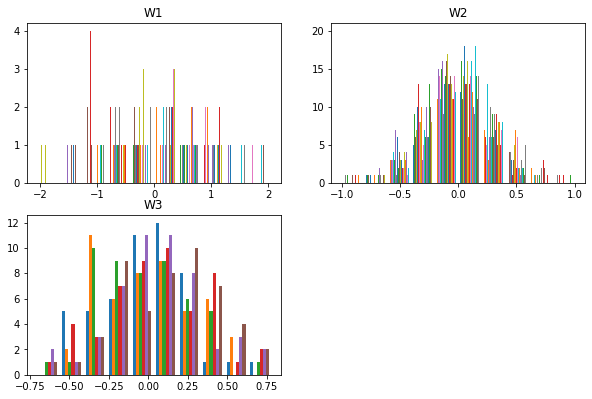

In [46]:
                #     print("Network params Saved ")

#                     (_, _), (x_test, t_test) = load_AReM(one_hot_label=False)

#                     network = Model(layer_unit)

#                     tester = Tester(network, x_test, t_test)
#                 #     args = arg()

#                     network.load_params(args.sf)


#                     # 배치사이즈100으로 accuracy test, 다른 배치사이즈로 학습했다면 결과가 달라질 수 있습니다.
#                     test_acc, inference_time = tester.accuracy(x_test, t_test)
# #                     file = open('./Result/SGD/[si_{}]_[ep_{}]_[ba_{}]_[lr_{}]_[la_{}].txt'\
# #                                         .format(len(layer_unit), epoch, batch, lr, layer_unit), 'a')
# #                     file.write("=============== Final Test Accuracy ===============\n")
# #                     file.write("test acc: %f,  " % test_acc)
# #                     file.write("inference_time: %f\n" % inference_time)
# #                     file.close()
#                     print("=============== Final Test Accuracy ===============")
#                     print("test acc:" + str(round(test_acc,3)) + ", inference_time:" + str(inference_time))
#                     print("\n=========================================================\n\n\n")